In [1]:
import mat73
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
bg_data_path = "data/downloads/U09_Background.mat"
wt_data_path = "data/downloads/U09_Wind%20turbine.mat"

In [3]:
bg_data_dict = mat73.loadmat(bg_data_path)
wt_data_dict = mat73.loadmat(wt_data_path)

In [4]:
bg_data_dict.keys()

dict_keys(['Sig_Mic_bg'])

In [5]:
wt_data_dict.keys()

dict_keys(['Sig_Mic_rotating'])

### Extract the data from the dictionary

In [6]:
bg_data_dict['Sig_Mic_bg'].shape == wt_data_dict['Sig_Mic_rotating'].shape

True

In [7]:
df_bg = pd.DataFrame(bg_data_dict['Sig_Mic_bg'])
df_wt = pd.DataFrame(wt_data_dict['Sig_Mic_rotating'])

sample_rate = 48128

# Swap sample number for seconds
df_bg.columns = df_bg.columns/sample_rate
df_wt.columns = df_wt.columns/sample_rate

# Get mean of each col with concat. Index is time in s, value is mean of all mics (rows)
df_bg_mean = pd.concat([df_bg.mean(axis=0)], axis=1)
df_wt_mean = pd.concat([df_wt.mean(axis=0)], axis=1)

# Rename cols
df_bg_mean.columns = ["mean"]
df_wt_mean.columns = ["mean"]

### Apply FFT on mean signal

In [8]:
# Convert the dataframe to a numpy array
signal_bg = df_bg_mean["mean"].values
signal_wt = df_wt_mean["mean"].values

# Calculate the FFT of the signal with numpy
signal_fft_bg = np.fft.fft(signal_bg)
signal_fft_wt = np.fft.fft(signal_wt)

# Calculate the frequency axis
freq_bg = np.fft.fftfreq(signal_bg.size, d=1/sample_rate)
freq_wt = np.fft.fftfreq(signal_wt.size, d=1/sample_rate)

# Create new dataframe for FFT results (absolute value, only positive frequencies)
df_bg_fft = pd.DataFrame({"freq": freq_bg, "fft": np.abs(signal_fft_bg)})
df_bg_fft = df_bg_fft.loc[df_bg_fft["freq"] > 0]

df_wt_fft = pd.DataFrame({"freq": freq_wt, "fft": np.abs(signal_fft_wt)})
df_wt_fft = df_wt_fft.loc[df_wt_fft["freq"] > 0]

# Smooth the FFT results
df_bg_fft["fft"] = df_bg_fft["fft"].rolling(20).mean()
df_wt_fft["fft"] = df_wt_fft["fft"].rolling(20).mean()

# Denoise the WT signal
df_wt_bg_fft = df_wt_fft.copy()
df_wt_bg_fft["fft"] = df_wt_bg_fft["fft"] - df_bg_fft["fft"]
df_wt_bg_fft.loc[df_wt_bg_fft["fft"] < 0, "fft"] = 0

# Detect harmonics
harmonics_bg, _ = find_peaks(df_bg_fft["fft"], height=[200,1500], prominence=250, distance=100)
harmonics_wt, _ = find_peaks(df_wt_fft["fft"], height=[200,1500], prominence=250, distance=100)
harmonics_wt_bg, _ = find_peaks(df_wt_bg_fft["fft"], height=[200,1500], prominence=250, distance=100)

### Plot the FFT results

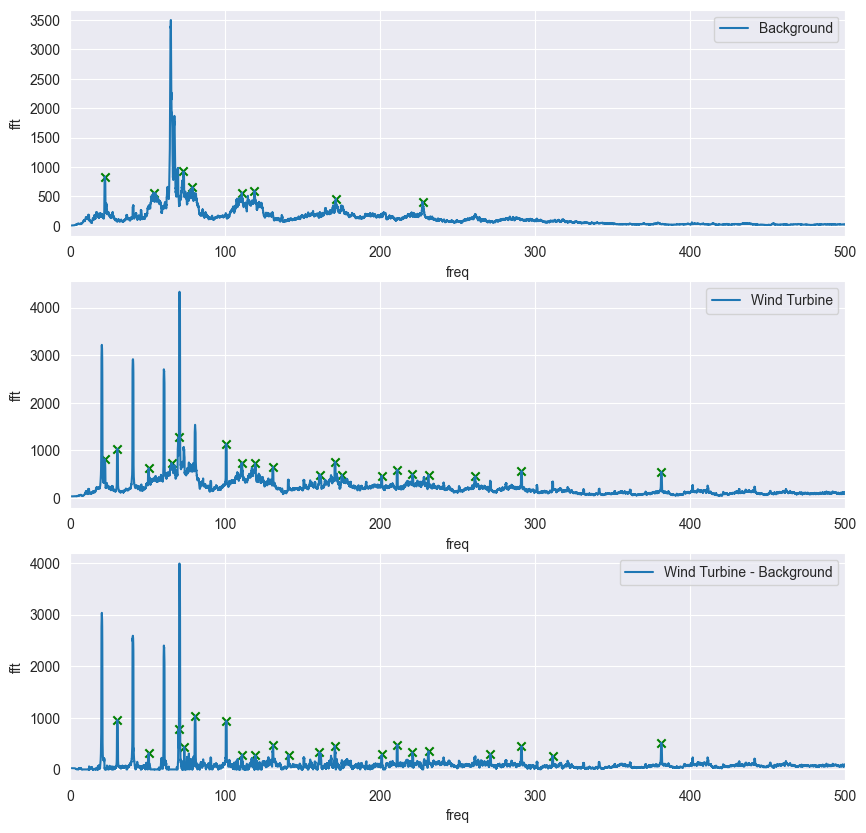

In [9]:
x_lim_0 = 0
x_lim_1 = 500
# Create subplots, with seaborn
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

sns.lineplot(data=df_bg_fft, x="freq", y="fft", ax=ax[0], label="Background")
ax[0].set_xlim(x_lim_0, x_lim_1)
sns.lineplot(data=df_wt_fft, x="freq", y="fft", ax=ax[1], label="Wind Turbine")
ax[1].set_xlim(x_lim_0, x_lim_1)
sns.lineplot(data=df_wt_bg_fft, x="freq", y="fft", ax=ax[2], label="Wind Turbine - Background")
ax[2].set_xlim(x_lim_0, x_lim_1)

# Plot harmonics
ax[0].scatter(df_bg_fft["freq"].iloc[harmonics_bg], df_bg_fft["fft"].iloc[harmonics_bg], marker="x", color="green", label="Harmonics")
ax[1].scatter(df_wt_fft["freq"].iloc[harmonics_wt], df_wt_fft["fft"].iloc[harmonics_wt], marker="x", color="green", label="Harmonics")
ax[2].scatter(df_wt_bg_fft["freq"].iloc[harmonics_wt_bg], df_wt_bg_fft["fft"].iloc[harmonics_wt_bg], marker="x", color="green", label="Harmonics")

### Split df_bg and df_wt into 1/2s samples and apply FFT on each sample

In [107]:
sample_rate = 48128

# Iterate over every sample_rate/2 samples
df_bg_fft_list = []
df_wt_fft_list = []
df_wt_bg_fft_list = []

for sample in range(0, len(df_bg_mean), int(sample_rate/2)):
    # Get the sample
    df_bg_sample = df_bg_mean.iloc[sample:sample+int(sample_rate/2)]
    df_wt_sample = df_wt_mean.iloc[sample:sample+int(sample_rate/2)]

    # Convert the dataframe to a numpy array
    signal_bg = df_bg_sample["mean"].values
    signal_wt = df_wt_sample["mean"].values

    # Calculate the FFT of the signal with numpy
    signal_fft_bg = np.fft.fft(signal_bg)
    signal_fft_wt = np.fft.fft(signal_wt)

    # Calculate the frequency axis
    freq_bg = np.fft.fftfreq(signal_bg.size, d=1/sample_rate)
    freq_wt = np.fft.fftfreq(signal_wt.size, d=1/sample_rate)

    # Create new dataframe for FFT results (absolute value, only positive frequencies)
    df_bg_fft_sample = pd.DataFrame({"freq": freq_bg, "fft": np.abs(signal_fft_bg)})
    df_bg_fft_sample = df_bg_fft_sample.loc[df_bg_fft_sample["freq"] > 0]

    df_wt_fft_sample = pd.DataFrame({"freq": freq_wt, "fft": np.abs(signal_fft_wt)})
    df_wt_fft_sample = df_wt_fft_sample.loc[df_wt_fft_sample["freq"] > 0]

    df_wt_bg_fft_sample = df_wt_fft_sample.copy()
    df_wt_bg_fft_sample["fft"] = df_wt_bg_fft_sample["fft"] - df_bg_fft_sample["fft"]
    df_wt_bg_fft_sample.loc[df_wt_bg_fft_sample["fft"] < 0, "fft"] = 0

    # Smooth the FFT results
    df_bg_fft_sample["fft"] = df_bg_fft_sample["fft"].rolling(20).mean()
    df_wt_fft_sample["fft"] = df_wt_fft_sample["fft"].rolling(20).mean()
    df_wt_bg_fft_sample["fft"] = df_wt_bg_fft_sample["fft"].rolling(20).mean()

    # Denoise the WT signal
    df_wt_bg_fft_sample = df_wt_fft_sample.copy()
    df_wt_bg_fft_sample["fft"] = df_wt_bg_fft_sample["fft"] - df_bg_fft_sample["fft"]
    df_wt_bg_fft_sample.loc[df_wt_bg_fft_sample["fft"] < 0, "fft"] = 0

    # Add sample number to the dataframe
    df_bg_fft_sample["sample"] = sample
    df_wt_fft_sample["sample"] = sample
    df_wt_bg_fft_sample["sample"] = sample

    # Add the sample to the list
    df_bg_fft_list.append(df_bg_fft_sample)
    df_wt_fft_list.append(df_wt_fft_sample)
    df_wt_bg_fft_list.append(df_wt_bg_fft_sample)

In [112]:
# Merge the list of dataframes into one dataframe
df_bg_fft = pd.concat(df_bg_fft_list)
df_wt_fft = pd.concat(df_wt_fft_list)
df_wt_bg_fft = pd.concat(df_wt_bg_fft_list)

In [113]:
df_bg_fft

,freq,fft,sample
1,2.0,NaN,0
2,4.0,NaN,0
3,6.0,NaN,0
4,8.0,NaN,0
5,10.0,NaN,0
...,...,...,...
12027,24054.0,0.014209,1419776
12028,24056.0,0.014262,1419776
12029,24058.0,0.013972,1419776
12030,24060.0,0.013556,1419776


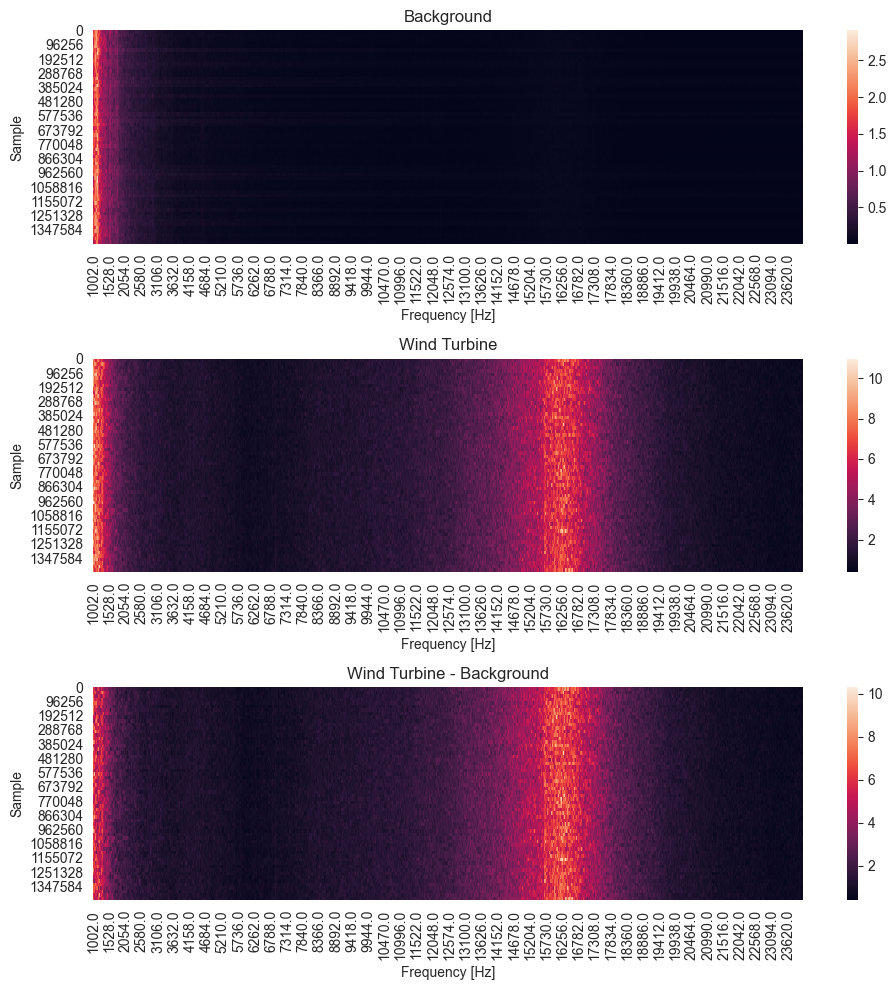

In [125]:
# Plot heatmap of the FFT results. Only plot frequencies in range:
f_lb = 1000
f_ub = 25000

df_bg_fft_ = df_bg_fft.loc[(df_bg_fft["freq"] > f_lb) & (df_bg_fft["freq"] < f_ub)]
df_wt_fft_ = df_wt_fft.loc[(df_wt_fft["freq"] > f_lb) & (df_wt_fft["freq"] < f_ub)]
df_wt_bg_fft_ = df_wt_bg_fft.loc[(df_wt_bg_fft["freq"] > f_lb) & (df_wt_bg_fft["freq"] < f_ub)]

# Create subplots, with seaborn
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
sns.heatmap(df_bg_fft_.pivot("sample", "freq", "fft"), ax=ax[0])
sns.heatmap(df_wt_fft_.pivot("sample", "freq", "fft"), ax=ax[1])
sns.heatmap(df_wt_bg_fft_.pivot("sample", "freq", "fft"), ax=ax[2])

ax[0].set_title("Background")
ax[1].set_title("Wind Turbine")
ax[2].set_title("Wind Turbine - Background")

ax[0].set_xlabel("Frequency [Hz]")
ax[1].set_xlabel("Frequency [Hz]")
ax[2].set_xlabel("Frequency [Hz]")

ax[0].set_ylabel("Sample")
ax[1].set_ylabel("Sample")
ax[2].set_ylabel("Sample")

plt.tight_layout()